Imports

In [87]:
from pandas.core.interchange.dataframe_protocol import DataFrame
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [88]:
import pandas as pd

Load datasets

In [89]:
def read_csv(filename):
    df = pd.read_csv(
        filename,
        header=0,  # Use the first row as the header
        delimiter=';',  # Use semicolon as the main delimiter
        decimal=',',  # Specify that commas are used as decimals
        quotechar='"',  # Handle quotes around strings
        skipinitialspace=True,  # Skip spaces after delimiters
    )
    df.set_index(df.columns[0], inplace=True)
    return df

airlines = read_csv('airlines.csv')
airports = read_csv('airports.csv')
planes = read_csv('planes.csv')
flights = read_csv('flights.csv')
weather = read_csv('weather.csv')

In [90]:
def check_for_nulls(df):
    res = {}
    for c in df.columns:
        if df[df[c].isnull()].shape[0] != 0:
            res[c] = df[df[c].isnull()].shape[0]
    return res

In [91]:
print("Nullable columns in airlines:", check_for_nulls(airlines))
print("Nullable columns in airports:", check_for_nulls(airports))
print("Nullable columns in planes:", check_for_nulls(planes))
print("Nullable columns in flights:", check_for_nulls(flights))
print("Nullable columns in weather:", check_for_nulls(weather))

Nullable columns in airlines: {}
Nullable columns in airports: {'tz': 48, 'dst': 48, 'tzone': 119}
Nullable columns in planes: {'year': 89}
Nullable columns in flights: {'dep_time': 10738, 'dep_delay': 10738, 'arr_time': 11453, 'arr_delay': 12534, 'tailnum': 1913, 'air_time': 12534}
Nullable columns in weather: {'temp': 25536, 'dewp': 25536, 'humid': 25536, 'wind_dir': 1220, 'wind_speed': 1033, 'wind_gust': 1033, 'precip': 24611, 'pressure': 25632, 'visib': 24}


Clean Datasets

In [92]:
def clear_airports(df):
    # I checked that tz is null = dst is null
    df = df.dropna(subset=['tz', 'dst'])
    for idx, row in df[df['tzone'].isnull()].iterrows():
        matching_row = df[(df['tz'] == row['tz']) & pd.notnull(df['tzone'])]
        if not matching_row.empty:
            df.at[idx, 'tzone'] = matching_row['tzone'].iloc[0]
        else:
            df = df.drop(idx)
    return df

In [93]:
def clear_planes(df):
    return df.dropna()

In [94]:
def clear_flights(df):
    # I checked that dep_time is null = dep_delay is null \subset arr_time is null \subset arr_delay is null \subset air_time is null
    df = df.dropna(subset=['arr_time', 'tailnum'])
    for idx, row in df[df['air_time'].isnull()].iterrows():
        df.at[idx, 'arr_delay'] = df['arr_time'].iloc[0] - df['sched_arr_time'].iloc[0]
        df.at[idx, 'air_time'] = df['arr_time'].iloc[0] - df['dep_time'].iloc[0]
    return df

In [95]:
def clear_weather(df):
    # I checked that precip is null \subset temp is null = dewp is null = humid is null \subset pressure is null
    return df

In [96]:
clean_airlines = airlines
clean_airports = clear_airports(airports.copy())
clean_planes = clear_planes(planes.copy())
clean_flights = clear_flights(flights.copy())
clean_weather = clear_weather(weather.copy())

In [97]:
print("Nullable columns in airlines:", check_for_nulls(clean_airlines))
print("Nullable columns in airports:", check_for_nulls(clean_airports))
print("Nullable columns in planes:", check_for_nulls(clean_planes))
print("Nullable columns in flights:", check_for_nulls(clean_flights))
print("Nullable columns in weather:", check_for_nulls(clean_weather))

Nullable columns in airlines: {}
Nullable columns in airports: {}
Nullable columns in planes: {}
Nullable columns in flights: {}
Nullable columns in weather: {'temp': 25536, 'dewp': 25536, 'humid': 25536, 'wind_dir': 1220, 'wind_speed': 1033, 'wind_gust': 1033, 'precip': 24611, 'pressure': 25632, 'visib': 24}


In [98]:
print("Airports old vs new:", airports.shape, clean_airports.shape)
print("Planes old vs new:", planes.shape, clean_planes.shape)
print("Flights old vs new:", flights.shape, clean_flights.shape)
print("Weather old vs new:", weather.shape, clean_weather.shape)

Airports old vs new: (1251, 8) (1194, 8)
Planes old vs new: (4840, 9) (4751, 9)
Flights old vs new: (435352, 19) (423899, 19)
Weather old vs new: (26204, 15) (26204, 15)


In [99]:
import numpy as np

all_tables = [clean_airlines, clean_airports, clean_planes, clean_flights, clean_weather]


# Gets additional value such as min / median / max etc.
def column_summary(df):
    result_df = pd.DataFrame({
        'col_name': pd.Series(dtype='str'),
        'col_dtype': pd.Series(dtype='str'),
        'num_distinct_values': pd.Series(dtype='int'),
        'min_value': pd.Series(dtype='float'),
        'max_value': pd.Series(dtype='float'),
        'median_no_na': pd.Series(dtype='float'),
        'average_no_na': pd.Series(dtype='float'),
        'average_non_zero': pd.Series(dtype='float'),
        'null_present': pd.Series(dtype='bool'),
        'nulls_num': pd.Series(dtype='int'),
        'non_nulls_num': pd.Series(dtype='int'),
        'distinct_values': pd.Series(dtype='object'),
    })

    df = df.reset_index(drop=True)

    # Loop through each column in the DataFrame
    for column in df.columns:
        # Get column dtype
        col_dtype = df[column].dtype
        # Get distinct values and their counts
        value_counts = df[column].value_counts()
        distinct_values = value_counts.index.tolist()
        # Get number of distinct values
        num_distinct_values = len(distinct_values)
        # Get min and max values
        sorted_values = sorted(distinct_values)
        min_value = sorted_values[0] if sorted_values else None
        max_value = sorted_values[-1] if sorted_values else None

        # Get median value
        non_distinct_val_list = sorted(df[column].dropna().tolist())
        len_non_d_list = len(non_distinct_val_list)
        if len(non_distinct_val_list) == 0:
            median = None
        else:
            median = non_distinct_val_list[len_non_d_list // 2]

        # Get average value if value is number
        if np.issubdtype(df[column].dtype, np.number):
            if len(non_distinct_val_list) > 0:
                average = sum(non_distinct_val_list) / len_non_d_list
                non_zero_val_list = [v for v in non_distinct_val_list if v > 0]
                average_non_zero = sum(non_zero_val_list) / len_non_d_list
            else:
                average = None
                average_non_zero = None
        else:
            average = None
            average_non_zero = None

        # Check if null values are present
        null_present = 1 if df[column].isnull().any() else 0

        # Get number of nulls and non-nulls
        num_nulls = df[column].isnull().sum()
        num_non_nulls = df[column].notnull().sum()

        # Distinct_values only take top 10 distinct values count
        top_10_d_v = value_counts.head(10).index.tolist()
        top_10_c = value_counts.head(10).tolist()
        top_10_d_v_dict = dict(zip(top_10_d_v, top_10_c))

        # Append the information to the result DataFrame
        result_df = pd.concat([result_df, pd.DataFrame(
            [{'col_name': column, 'col_dtype': col_dtype, 'num_distinct_values': num_distinct_values,
              'min_value': min_value, 'max_value': max_value,
              'median_no_na': median, 'average_no_na': average, 'average_non_zero': average_non_zero,
              'null_present': null_present, 'nulls_num': num_nulls, 'non_nulls_num': num_non_nulls,
              'distinct_values': top_10_d_v_dict}])], ignore_index=True)

    return result_df


for table in all_tables:
    summary_df = (column_summary(table))
    display(summary_df)

,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,carrier,object,14,9E,YX,HA,None,None,0,0,14,"{'9E': 1, 'AA': 1, 'AS': 1, 'B6': 1, 'DL': 1, ..."
1,name,object,14,Alaska Airlines Inc.,United Air Lines Inc.,Hawaiian Airlines Inc.,None,None,0,0,14,"{'Endeavor Air Inc.': 1, 'American Airlines In..."


,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,faa,object,1194,AAF,ZPH,KWT,None,None,0,0,1194,"{'AAF': 1, 'NUQ': 1, 'NUI': 1, 'NTU': 1, 'NTD'..."
1,name,object,1191,Aberdeen Regional Airport,Zephyrhills Municipal Airport,Lebanon Municipal Airport,None,None,0,0,1194,"{'Capital City Airport': 3, 'Lawrence Municipa..."
2,lat,float64,1194,19.721399,71.285402,39.3806,41.032304,41.032304,0,0,1194,"{29.72750092: 1, 37.4161: 1, 70.2099990845: 1,..."
3,lon,float64,1192,-176.645996,174.113998,-96.184998,-103.724858,0.190983,0,0,1194,"{-118.1520004: 2, -112.375999451: 2, -85.02749..."
4,alt,int64,817,-115,9070,546,1104.854271,1105.030988,0,0,1194,"{13: 13, 24: 10, 21: 9, 8: 9, 26: 8, 17: 8, 18..."
5,tz,float64,7,-10.0,1.0,-6.0,-6.530151,0.000838,0,0,1194,"{-5.0: 405, -6.0: 304, -9.0: 171, -8.0: 153, -..."
6,dst,object,4,A,U,A,None,None,0,0,1194,"{'A': 1150, 'N': 22, 'U': 21, 'E': 1}"
7,tzone,object,9,America/Adak,Pacific/Honolulu,America/Los_Angeles,None,None,0,0,1194,"{'America/New_York': 405, 'America/Chicago': 3..."


,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,tailnum,object,4751,N101DQ,N999JQ,N604CZ,None,None,0,0,4751,"{'N101DQ': 1, 'N7828A': 1, 'N7827A': 1, 'N7826..."
1,year,float64,34,1990.0,2023.0,2012.0,2010.158072,2010.158072,0,0,4751,"{2001.0: 264, 2000.0: 264, 2014.0: 262, 2017.0..."
2,type,object,3,Fixed wing multi engine,Rotorcraft,Fixed wing multi engine,None,None,0,0,4751,"{'Fixed wing multi engine': 4749, 'Rotorcraft'..."
3,manufacturer,object,12,AIRBUS,EUROCOPTER DEUTSCHLAND GMBH,BOEING,None,None,0,0,4751,"{'BOEING': 2567, 'AIRBUS': 1078, 'AIRBUS INDUS..."
4,model,object,92,717-200,ERJ 190-100 IGW,777-222,None,None,0,0,4751,"{'737-8': 340, 'ERJ 170-200 LR': 337, 'A320-23..."
5,engines,int64,3,1,3,2,2.000421,2.000421,0,0,4751,"{2: 4747, 3: 3, 1: 1}"
6,seats,int64,44,4,563,182,190.270259,190.270259,0,0,4751,"{140: 419, 149: 348, 185: 340, 200: 311, 88: 3..."
7,speed,int64,1,0,0,0,0.0,0.0,0,0,4751,{0: 4751}
8,engine,object,4,Reciprocating,Turbo-shaft,Turbo-fan,None,None,0,0,4751,"{'Turbo-fan': 4546, 'Turbo-jet': 203, 'Turbo-s..."


/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/180409123.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame(
/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/180409123.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame(
/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/180409123.py:73: FutureWarning: The behavior of DataFrame concatenation with empty 

,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,year,int64,1,2023.0,2023.0,2023.0,2023.000000,2023.000000,0,0,423899,{2023: 423899}
1,month,int64,12,1.0,12.0,6.0,6.427569,6.427569,0,0,423899,"{3: 38919, 5: 38548, 10: 36531, 4: 36375, 8: 3..."
2,day,int64,31,1.0,31.0,16.0,15.705192,15.705192,0,0,423899,"{20: 14683, 17: 14567, 13: 14519, 19: 14516, 2..."
3,dep_time,float64,1365,1.0,2400.0,1356.0,1365.306276,1365.306276,0,0,423899,"{555.0: 1028, 556.0: 1005, 755.0: 990, 554.0: ..."
4,sched_dep_time,int64,1060,500.0,2359.0,1355.0,1358.074277,1358.074277,0,0,423899,"{600: 9069, 700: 6191, 800: 5755, 900: 5398, 6..."
5,dep_delay,float64,945,-50.0,1813.0,-2.0,13.735340,17.128196,0,0,423899,"{-5.0: 35715, -4.0: 29193, -6.0: 27450, -3.0: ..."
6,arr_time,float64,1433,1.0,2400.0,1519.0,1496.509204,1496.509204,0,0,423899,"{1012.0: 603, 1006.0: 593, 1004.0: 590, 1002.0..."
7,sched_arr_time,int64,1200,1.0,2359.0,1545.0,1547.082128,1547.082128,0,0,423899,"{2359: 1957, 1115: 1083, 1010: 1028, 1445: 102..."
8,arr_delay,float64,1019,-97.0,1812.0,-10.0,5.162517,17.633113,0,0,423899,"{-18.0: 9368, -14.0: 9261, -15.0: 9258, -17.0:..."
9,carrier,object,14,9E,YX,DL,NaN,NaN,0,0,423899,"{'YX': 85580, 'UA': 77659, 'B6': 64516, 'DL': ..."


/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/180409123.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame(
/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/180409123.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame(


,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,origin,object,3,EWR,LGA,JFK,NaN,NaN,0,0,26204,"{'JFK': 8735, 'EWR': 8735, 'LGA': 8734}"
1,year,int64,1,2023,2023,2023,2023.000000,2023.000000,0,0,26204,{2023: 26204}
2,month,int64,12,1,12,7,6.511449,6.511449,0,0,26204,"{1: 2232, 7: 2232, 8: 2232, 10: 2232, 5: 2231,..."
3,day,int64,31,1,31,16,15.679515,15.679515,0,0,26204,"{1: 864, 15: 864, 28: 864, 27: 864, 26: 864, 2..."
4,hour,int64,24,0,23,12,11.501336,11.501336,0,0,26204,"{0: 1092, 1: 1092, 22: 1092, 21: 1092, 20: 109..."
5,temp,float64,67,30.9,90.0,56.0,59.586377,59.586377,1,25536,668,"{51.0: 44, 52.0: 37, 48.0: 33, 50.0: 30, 49.0:..."
6,dewp,float64,72,17.1,75.0,49.0,47.195210,47.195210,1,25536,668,"{51.0: 41, 49.0: 30, 48.0: 27, 50.0: 27, 57.0:..."
7,humid,float64,435,15.98,100.0,67.28,67.366452,67.366452,1,25536,668,"{100.0: 49, 96.73: 11, 95.95: 10, 92.14: 7, 92..."
8,wind_dir,float64,37,0.0,360.0,200.0,188.123199,188.123199,1,1220,24984,"{0.0: 1256, 310.0: 1050, 180.0: 995, 320.0: 99..."
9,wind_speed,float64,31,0.0,37.97574,9.20624,9.439861,9.439861,1,1033,25171,"{5.7539: 4651, 12.65858: 2860, 8.05546: 2418, ..."


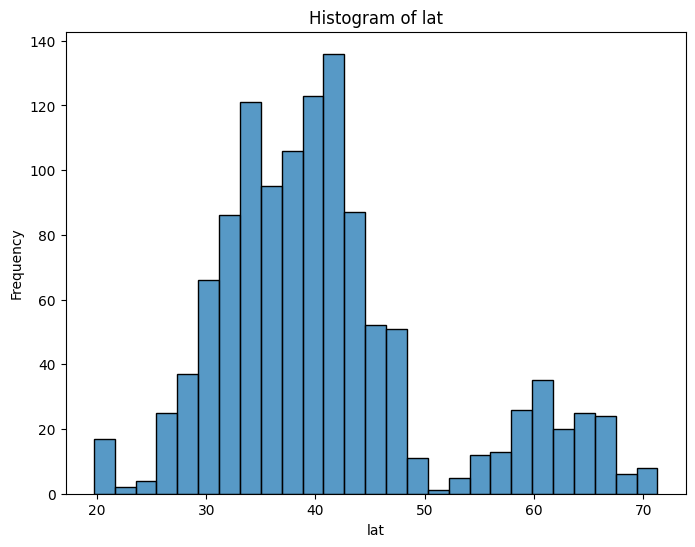

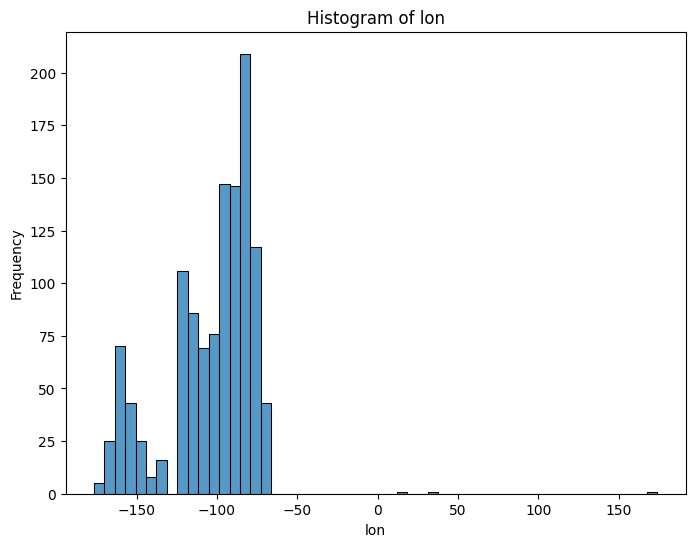

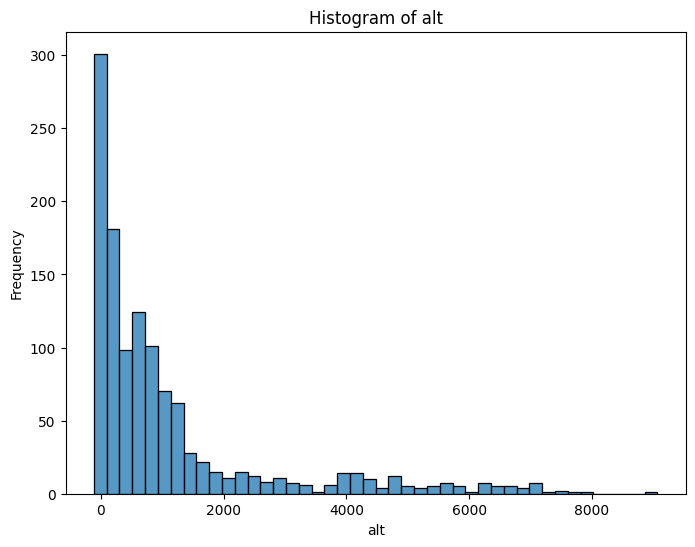

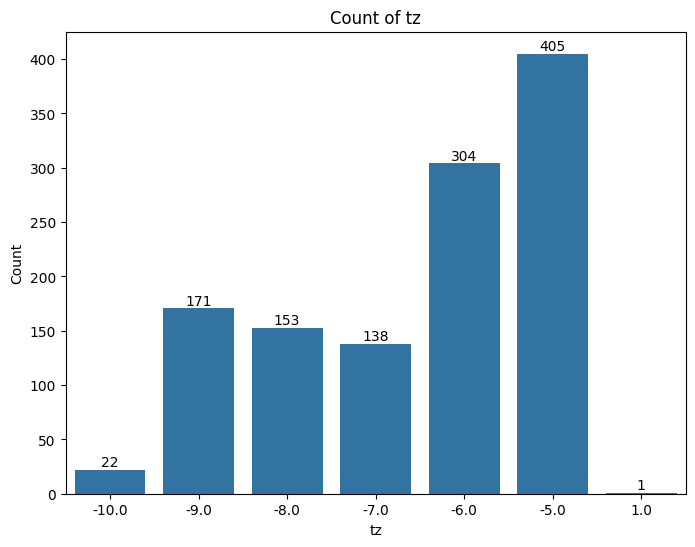

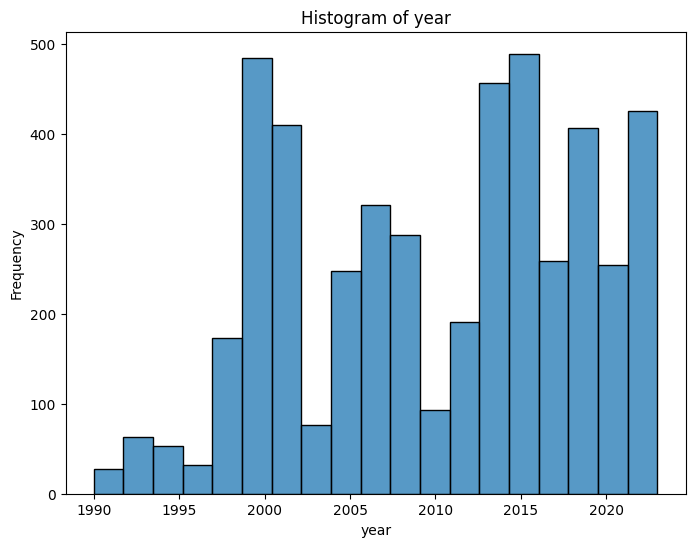

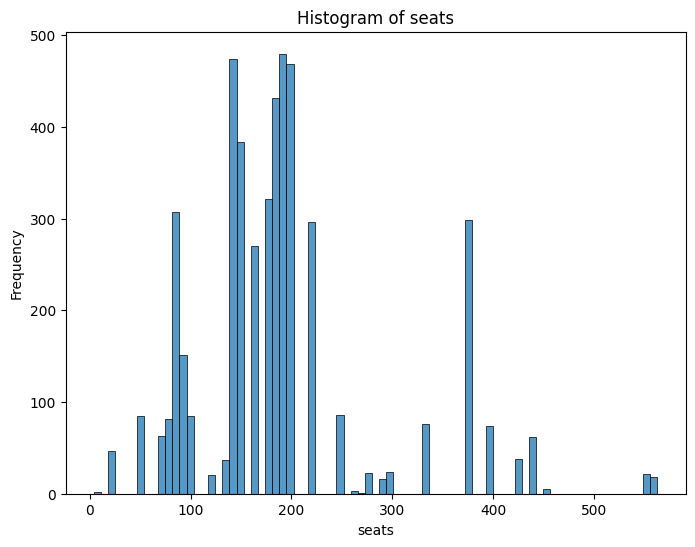

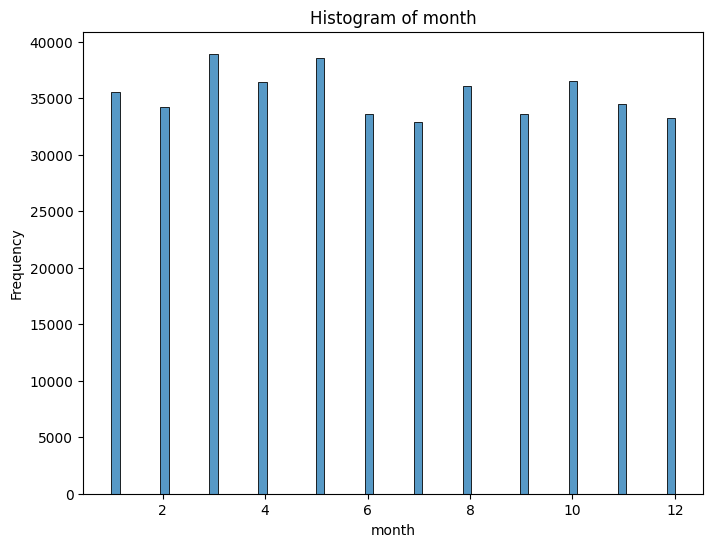

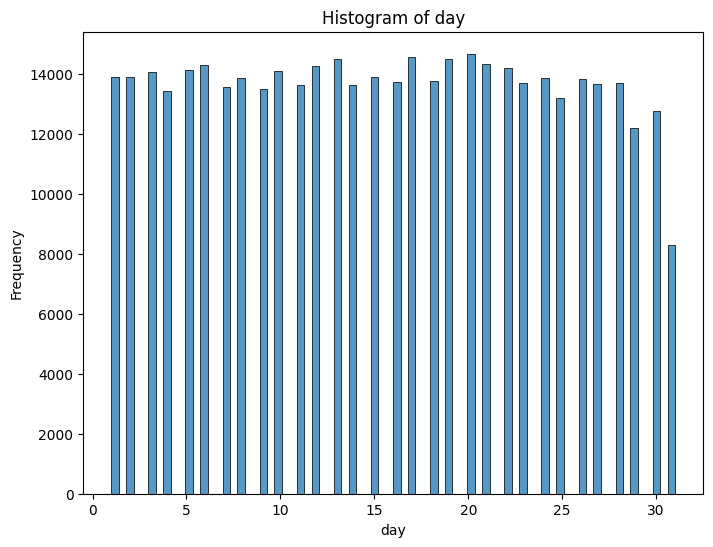

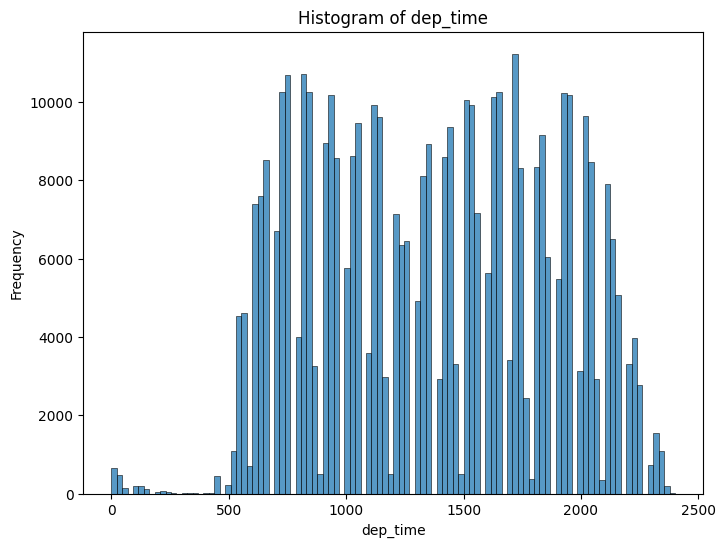

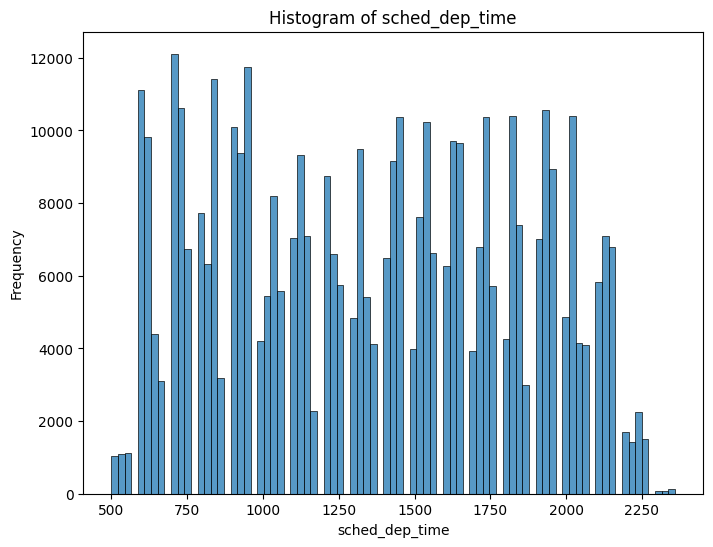

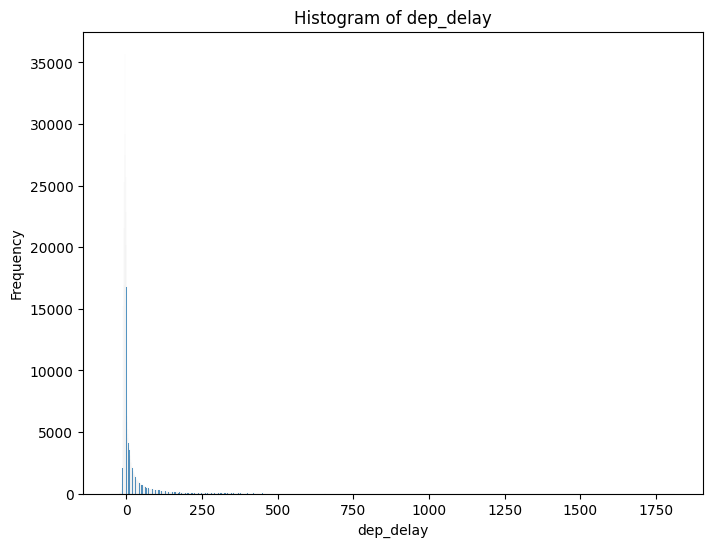

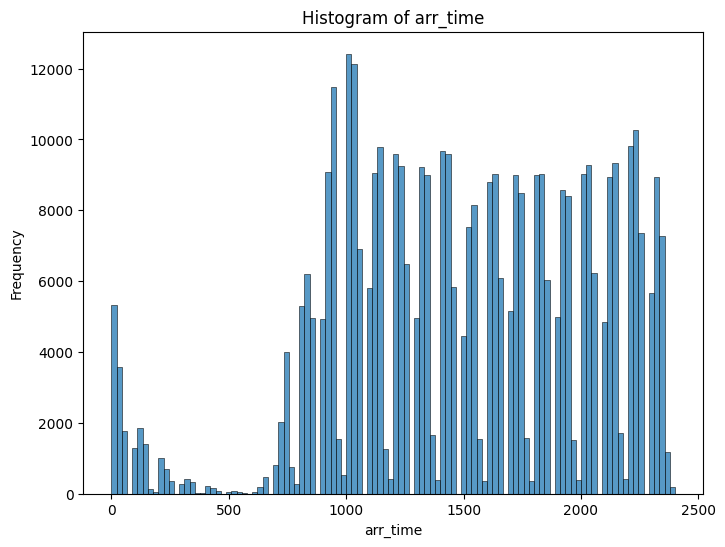

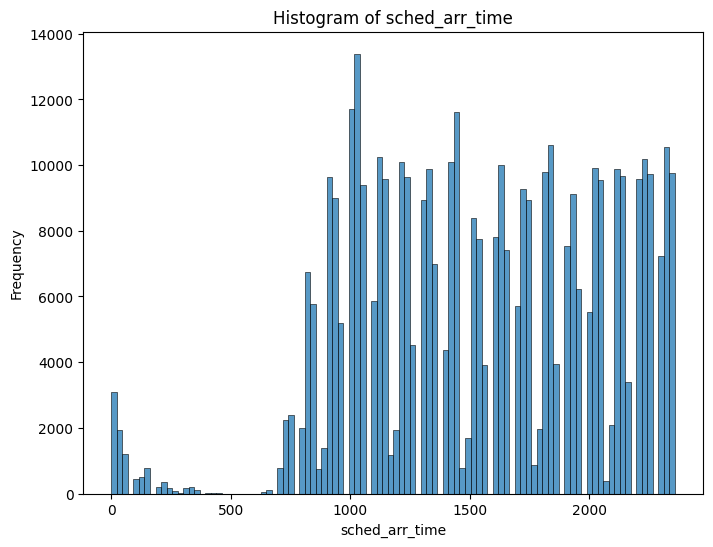

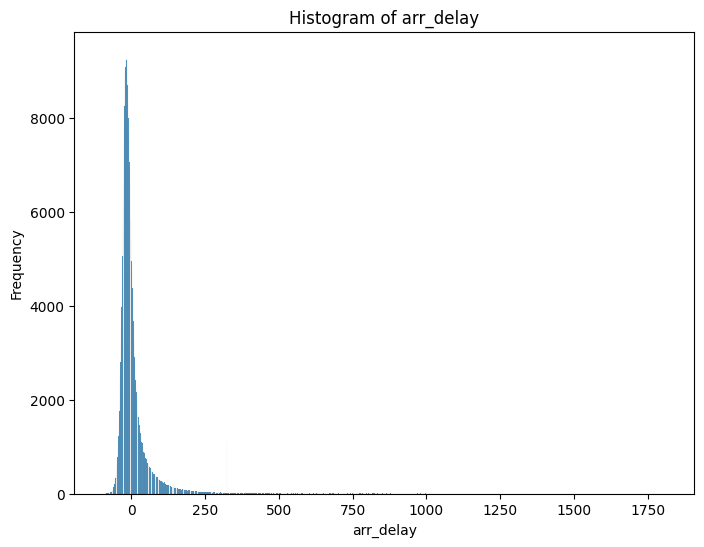

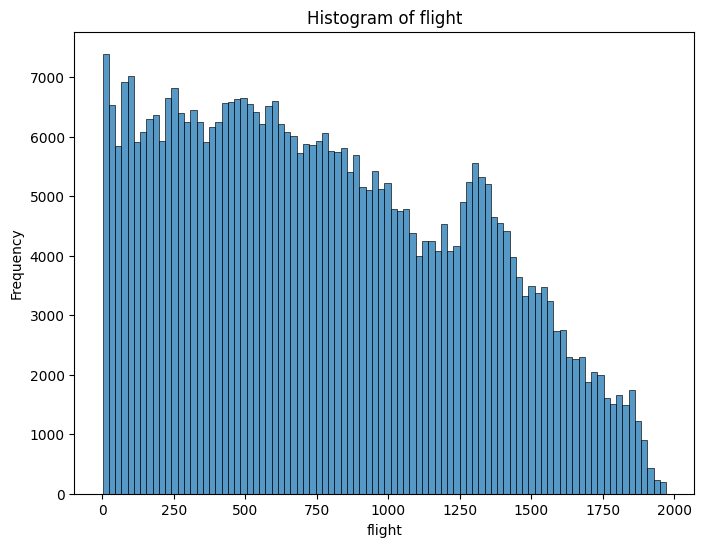

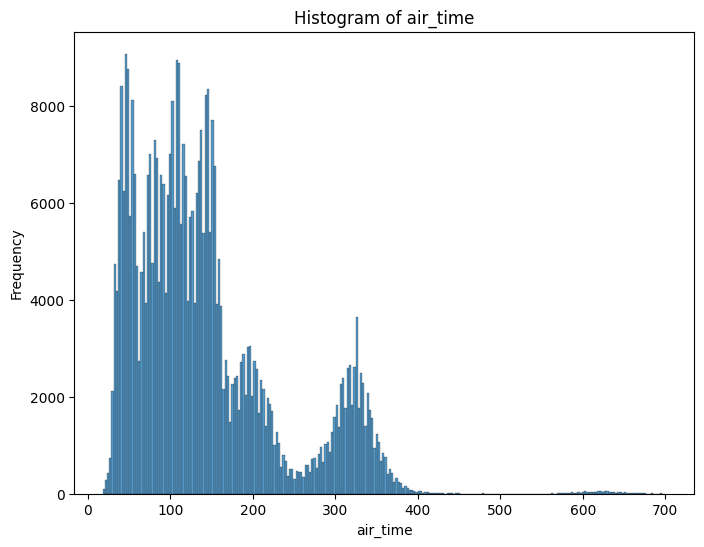

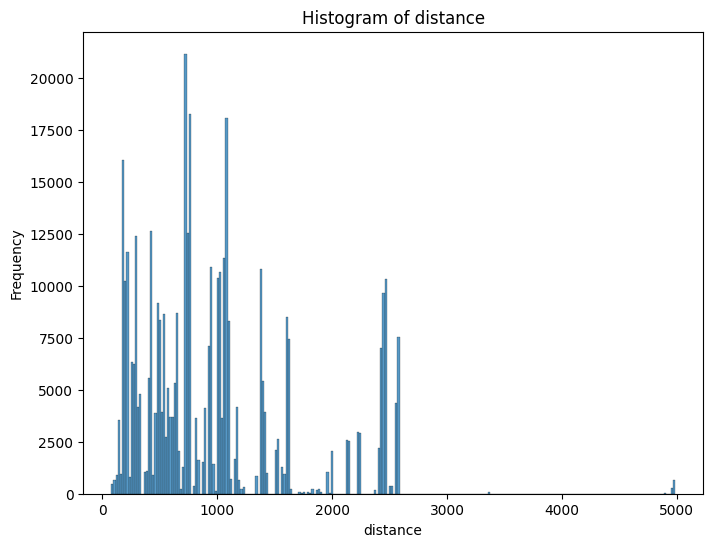

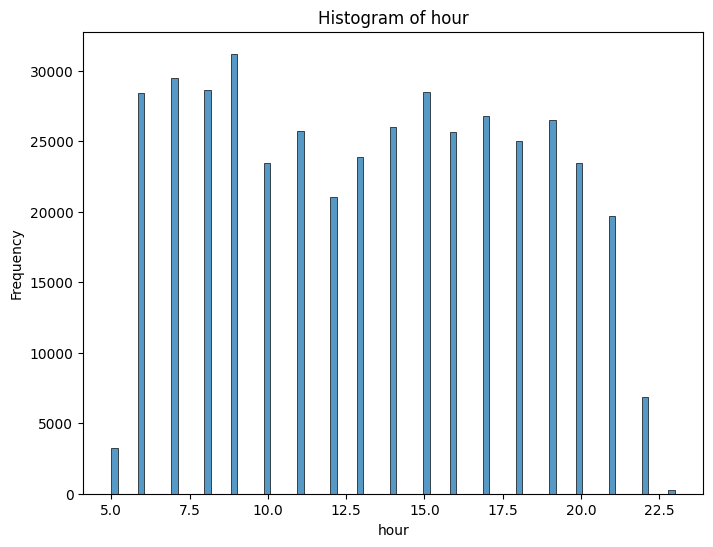

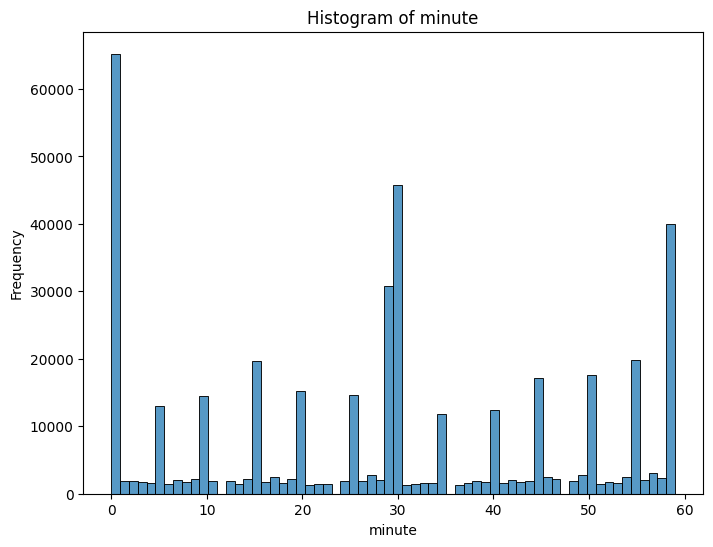

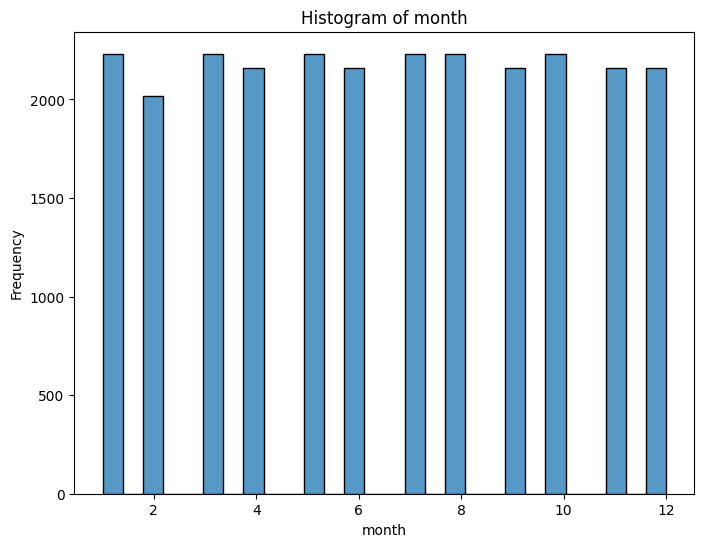

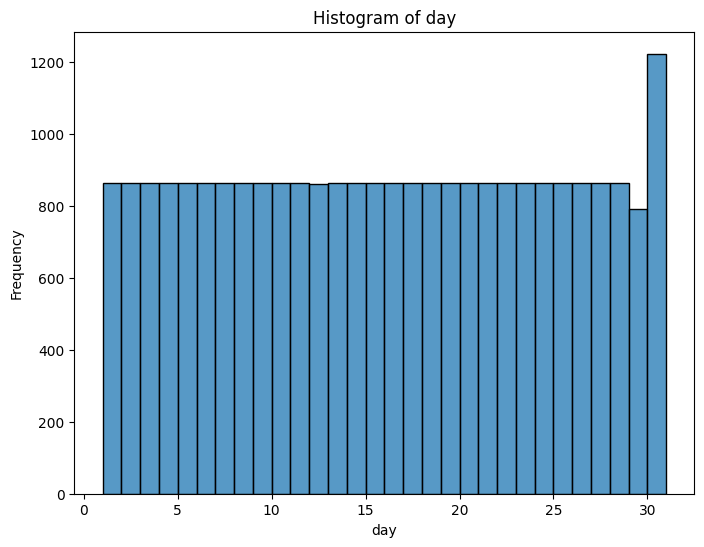

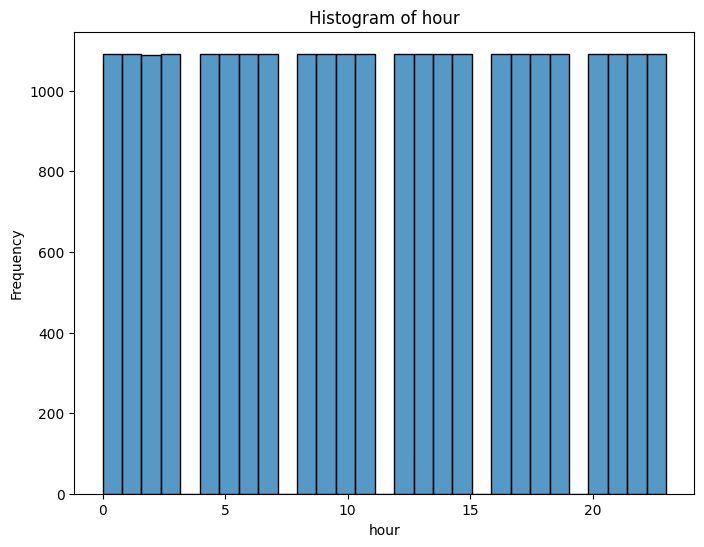

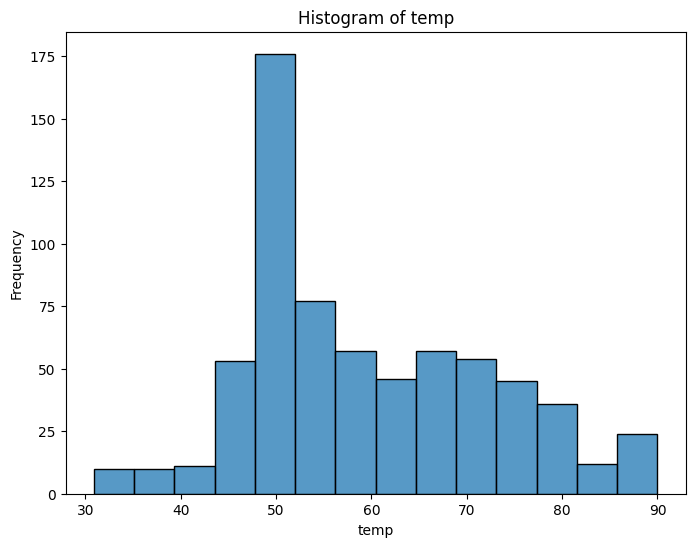

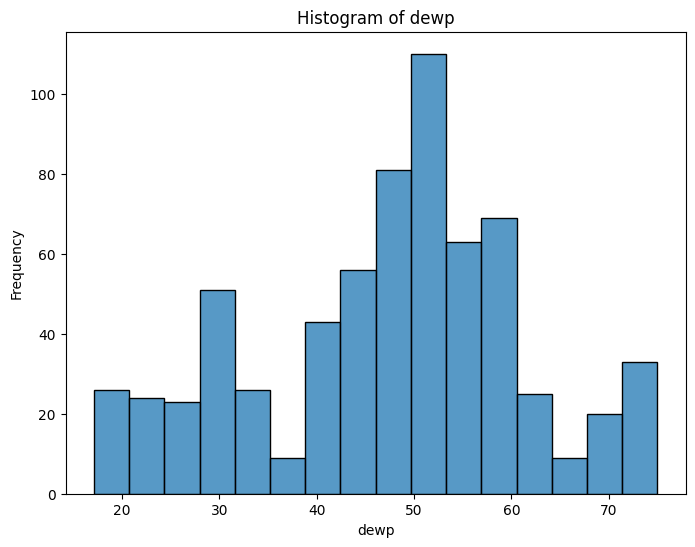

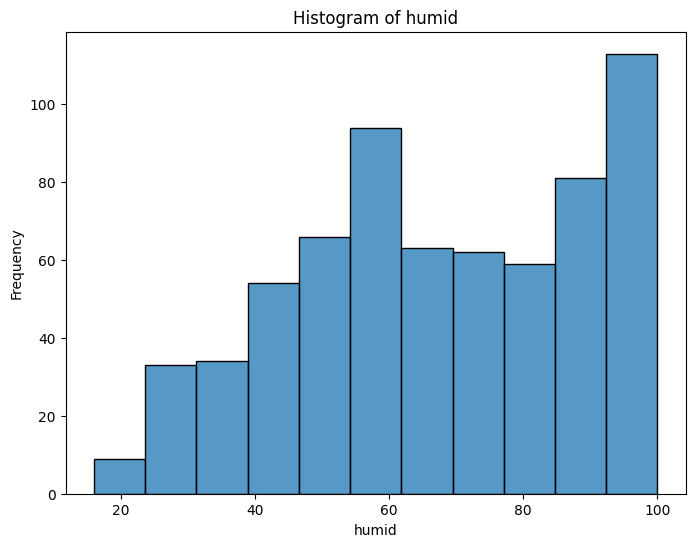

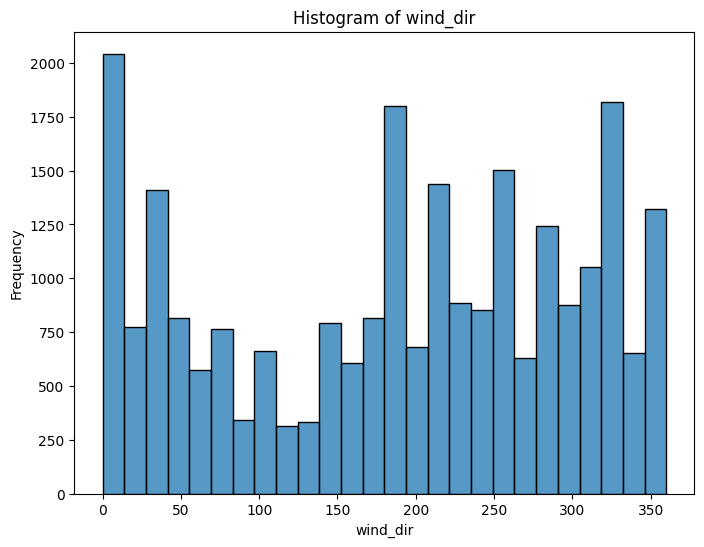

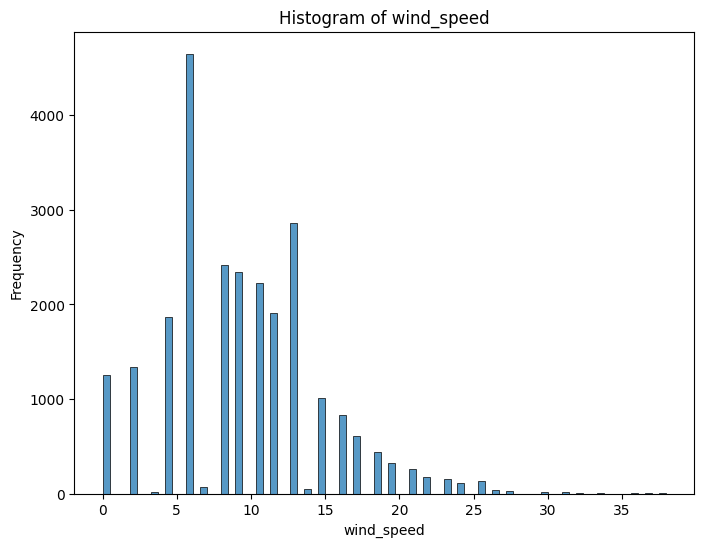

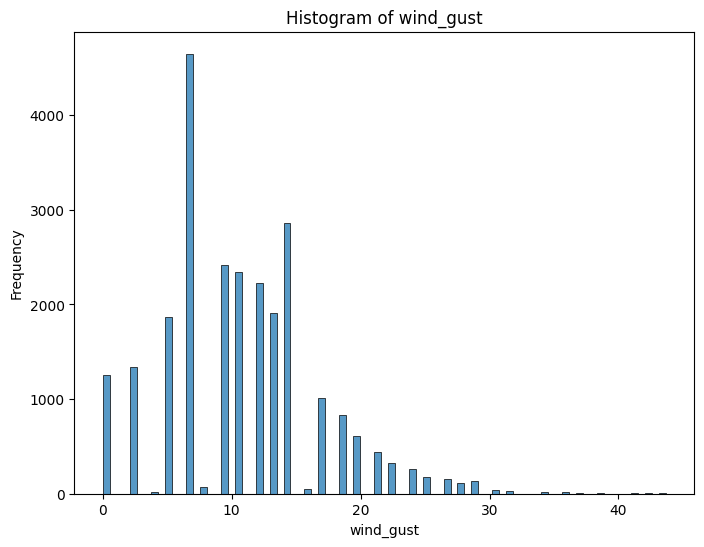

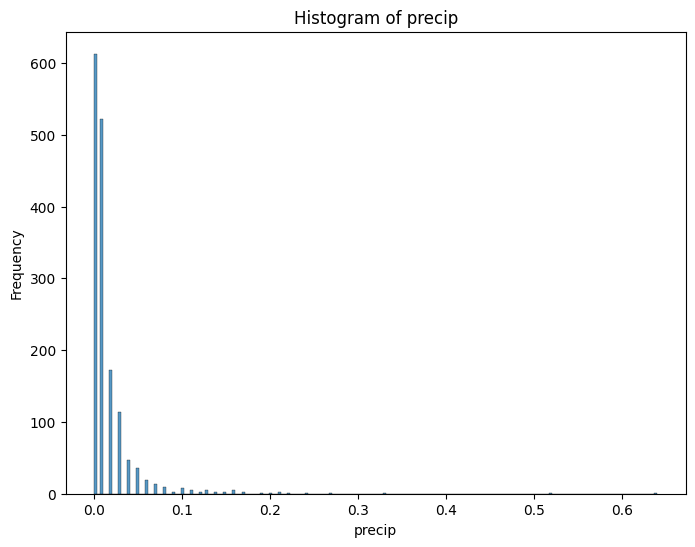

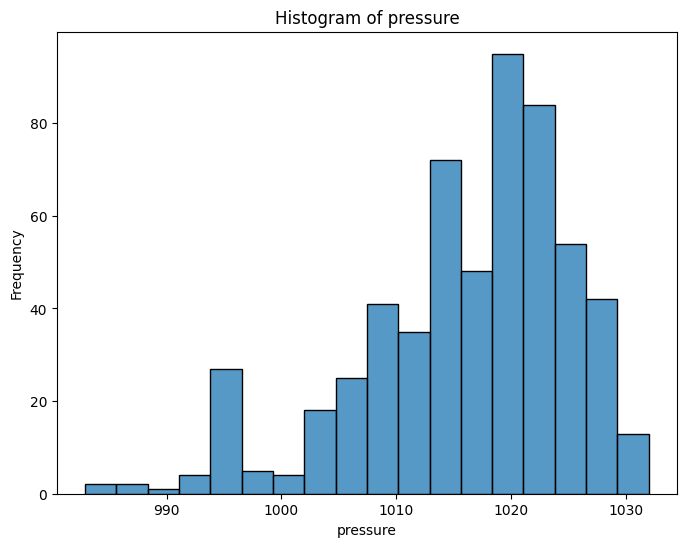

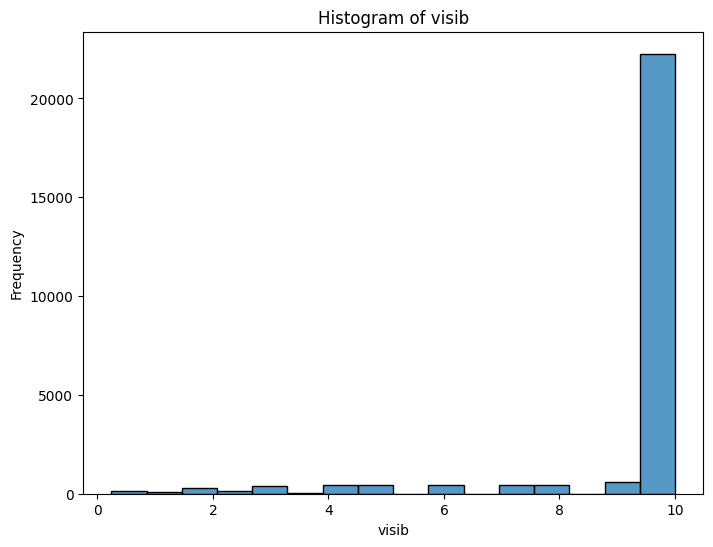

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

for df in all_tables:
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    
    # Perform univariate analysis on numerical columns
    for column in numerical_columns:
        # For continuous variables
        if len(df[column].unique()) > 10:  # Assuming if unique values > 10, consider it continuous
            plt.figure(figsize=(8, 6))
            sns.histplot(df[column])
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
        elif len(df[column].unique()) > 3:  # For discrete or ordinal variables
            plt.figure(figsize=(8, 6))
            ax = sns.countplot(x=column, data=df)
            plt.title(f'Count of {column}')
            plt.xlabel(column)
            plt.ylabel('Count')
            
            # Annotate each bar with its count
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 5), 
                            textcoords = 'offset points')
            plt.show()

/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/2921828212.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])


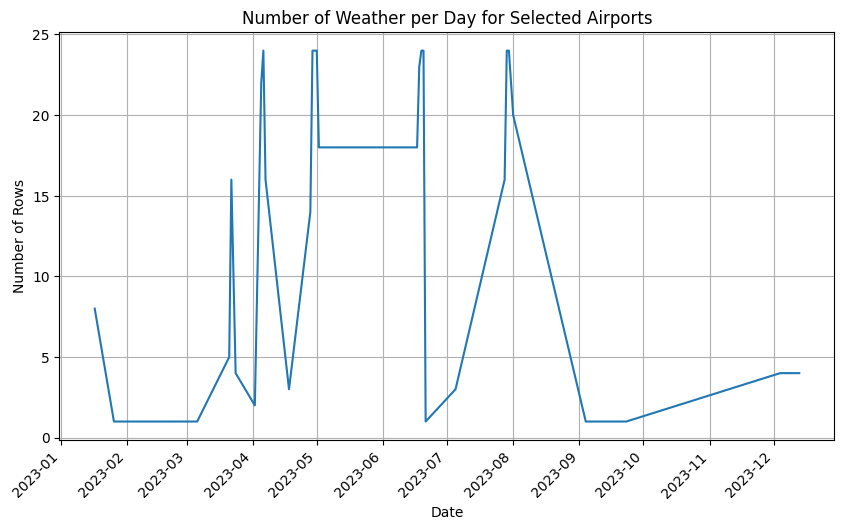

/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/2921828212.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])


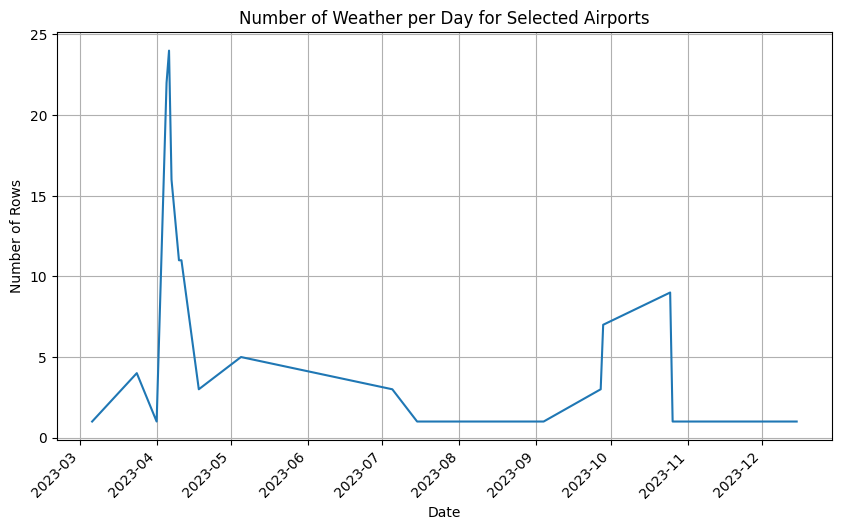

/var/folders/wc/qr6znyhd0_g77819klykdk8c0000gp/T/ipykernel_39738/2921828212.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])


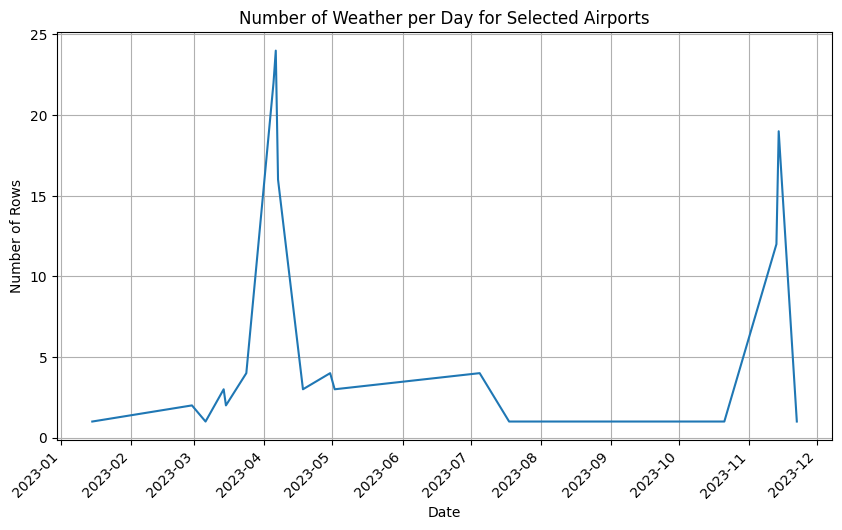

In [102]:
airports = ["JFK", "EWR", "LGA"]

for airport in airports:
    filtered_weather = clean_weather[clean_weather['origin'].eq(airport) 
                                     & clean_weather['temp'].notnull() 
                                     & clean_weather['dewp'].notnull() 
                                     & clean_weather['humid'].notnull()]
    
    # Group by year, month, and day, and count the number of occurrences for each day
    filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])    
    daily_counts = filtered_weather.groupby('date').size()
    
    plt.figure(figsize=(10, 6))
    daily_counts.plot(kind='line', title='Number of Weather per Day for Selected Airports')
    plt.xlabel('Date')
    plt.ylabel('Number of Rows')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
corr_df = df.iloc[:, 1:-3].corr()
corr_df